# Clustering


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from transformers import pipeline
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

In [6]:
df = pd.read_csv("C:/Users/LENOVO\Desktop/Patient-Satisfaction-and-Characteristics-in-Psychiatric-Hospitals-2017-1/data/processed/cleaned_data_ready_for_work.csv")
df.head()

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17552\3657897466.py:1: SyntaxWarning: invalid escape sequence '\D'
  df = pd.read_csv("C:/Users/LENOVO\Desktop/Patient-Satisfaction-and-Characteristics-in-Psychiatric-Hospitals-2017-1/data/processed/cleaned_data_ready_for_work.csv")


,id,hospital,migdar,machlaka,sugmigdar,migdarmachlaka,sugmachlaka,hosp_size,hosp_owner,sector,...,q41,q42,q43,q44,q71,q72,q73,q74,q75,q76
0,129600,4,2,מיון והשהיה,מעורבת,3,1,3,1,3,...,1,1,2,2,1.000000,1.0,1.000000,1.000000,1.0,1.000000
1,129602,4,1,מיון והשהיה,מעורבת,3,1,3,1,1,...,1,1,2,2,0.666667,1.0,0.500000,1.000000,1.0,0.666667
2,129603,4,2,מיון והשהיה,מעורבת,3,1,3,1,1,...,9,1,2,2,0.666667,0.0,1.000000,0.666667,1.0,0.666667
3,129605,4,1,מיון והשהיה,מעורבת,3,1,3,1,4,...,1,1,2,2,1.000000,1.0,0.666667,1.000000,1.0,1.000000
4,129606,4,1,מיון והשהיה,מעורבת,3,1,3,1,1,...,2,1,2,3,0.666667,1.0,1.000000,0.666667,1.0,0.666667


## clustering

# Finding the Optimal Number of Clusters

This code evaluates the *optimal number of clusters (K) for K-Means clustering* using three different metrics:

*1️⃣* *Elbow Method (SSE - Sum of Squared Errors)* → Measures how compact the clusters are. The optimal K is where the SSE curve bends ("elbow point").  

*2️⃣* *Silhouette Score* → Measures how well-separated the clusters are. A higher score indicates better-defined clusters.  

*3️⃣* *Davies-Bouldin Index* → Measures the compactness and separation of clusters. A lower score is better.  

The goal is to analyze these three metrics and determine the best value of *K* for clustering the survey responses.  
*If all three metrics suggest the same K, it is likely the best choice.*

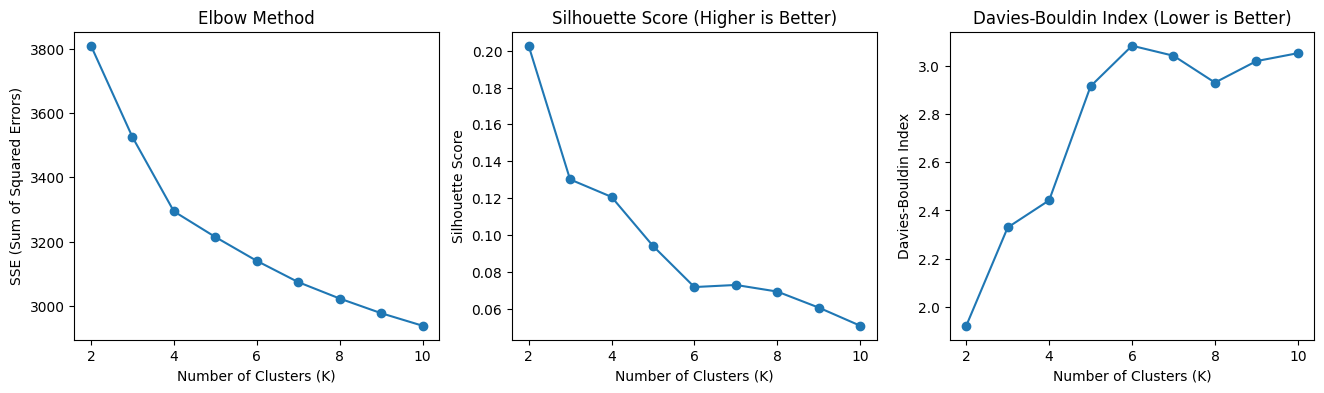

In [14]:
# טווח מספרי קלאסטרים לבדיקה
k_values = range(2, 11)

# משתנים לשמירת הערכים
sse = []  # לשיטת המרפק
silhouette_scores = []  # ציון סילואטה
db_scores = []  # ציון Davies-Bouldin
survey_columns = ['q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9',
'q10', 'q12', 'q13', 'q14', 'q15', 'q16', 'q17', 'q18', 'q19',
'q20', 'q21', 'q22', 'q23', 'q24', 'q25', 'q26', 'q27', 'q28', 'q29',
'q30', 'q31', 'q33', 'q34', 'q35', 'q36', 'q71', 'q72', 'q73', 'q74',
'q75', 'q76']

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(df[survey_columns])

    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df[survey_columns], cluster_labels))
    db_scores.append(davies_bouldin_score(df[survey_columns], cluster_labels))

# Elbow Method
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.plot(k_values, sse, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.title('Elbow Method')

# Silhouette Score
plt.subplot(1, 3, 2)
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score (Higher is Better)')

# Davies-Bouldin Index
plt.subplot(1, 3, 3)
plt.plot(k_values, db_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index (Lower is Better)')

plt.show()

# Choosing Between K=2 and K=4

After running the clustering evaluation, we found that the *Elbow Method* suggests *K=4, while the **Silhouette Score* and *Davies-Bouldin Index* suggest *K=2*.  
This creates a *trade-off* between choosing a simpler model with *2 clusters* or a more detailed segmentation with *4 clusters*.

### 📌 How to Decide?  
To determine whether *K=4* adds valuable information over *K=2, we analyze the **average survey responses for each cluster*:  
- *If K=4 shows meaningful differences in responses*, it justifies using 4 clusters.  
- *If the additional clusters are too similar*, K=2 might be a better choice.

---

# Analyzing Cluster Averages for K=4

The following code calculates and displays the *mean survey response for each cluster* when using *K=4*.  
This helps us understand whether *each cluster represents a distinct group* with unique characteristics.

In [49]:
# הצגת ממוצעי תשובות הסקר לכל קלאסטר ב-K=2
kmeans_2 = KMeans(n_clusters=2, random_state=42, n_init=10)
df['kmeans_cluster_2'] = kmeans_2.fit_predict(df[survey_columns])
df_cluster_k2 = df.groupby('kmeans_cluster_2')[survey_columns].mean()

df_cluster_k2

,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,...,q33,q34,q35,q36,q71,q72,q73,q74,q75,q76
kmeans_cluster_2,,,,,,,,,,,,,,,,,,,,,
0,0.726108,0.736121,0.702936,0.644214,0.623057,0.785838,0.759931,0.596718,0.601295,0.776770,...,0.711695,0.610104,0.577720,0.647956,0.655872,0.564767,0.769862,0.734456,0.729706,0.407168
1,0.845047,0.757475,0.832300,0.762016,0.699845,0.878295,0.823256,0.710336,0.673488,0.860724,...,0.680177,0.797674,0.685271,0.801292,0.805943,0.706460,0.852713,0.851938,0.841860,0.474160


In [38]:
# הצגת ממוצעי תשובות הסקר לכל קלאסטר ב-K=4
kmeans_4 = KMeans(n_clusters=4, random_state=42, n_init=10)
df['kmeans_cluster_4'] = kmeans_4.fit_predict(df[survey_columns])
df_cluster_k4 = df.groupby('kmeans_cluster_4')[survey_columns].mean()

df_cluster_k4

,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,...,q33,q34,q35,q36,q71,q72,q73,q74,q75,q76
kmeans_cluster_4,,,,,,,,,,,,,,,,,,,,,
0,0.759458,0.656426,0.722222,0.614695,0.536918,0.768817,0.700717,0.552569,0.500000,0.737754,...,0.653610,0.670251,0.534050,0.705496,0.672043,0.567503,0.730585,0.724612,0.720430,0.332139
1,0.907711,0.828454,0.910747,0.871585,0.821585,0.959927,0.916667,0.835610,0.801366,0.952641,...,0.701795,0.883880,0.786885,0.877960,0.903461,0.814208,0.936703,0.944444,0.929872,0.579235
2,0.575658,0.662124,0.512061,0.441886,0.419079,0.628289,0.595395,0.410088,0.423684,0.608553,...,0.675282,0.460526,0.437500,0.447003,0.455044,0.365132,0.655702,0.539474,0.560307,0.248904
3,0.827873,0.793651,0.835470,0.779915,0.759402,0.891026,0.866809,0.710114,0.723504,0.888889,...,0.733211,0.724359,0.690171,0.772792,0.793447,0.691595,0.858262,0.868234,0.846866,0.514957


# *Analyzing Standard Deviation in Clusters*

After calculating the *mean survey responses for each cluster, we also analyzed the **standard deviation (STD) within each cluster*.  

### *📌 Why Check Standard Deviation?*
Even if the *mean responses* of the clusters are different, we need to check if *the responses within each cluster are consistent* or *too scattered*:  
✔ *Low standard deviation* → The responses within the cluster are similar, meaning the cluster is well-defined.  
❌ *High standard deviation* → The responses within the cluster vary a lot, meaning the cluster might not be meaningful.

| *Standard Deviation* | *Meaning* |
|-----------------|------------------------------------------------------|
| *Close to 0* | All respondents in the cluster gave very similar answers → The cluster is well-defined. |
| *Between 0.05 - 0.15* | Some variation, but still a meaningful cluster. |
| *Above 0.2* | Large variation in responses → The cluster might not be meaningful. |
---

# *Checking Standard Deviation in K=4 Clusters*
The following code calculates the *standard deviation of survey responses within each cluster*

In [43]:
df.groupby('kmeans_cluster_4')[survey_columns].std()

,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,...,q33,q34,q35,q36,q71,q72,q73,q74,q75,q76
kmeans_cluster_4,,,,,,,,,,,,,,,,,,,,,
0,0.214537,0.308535,0.232286,0.286917,0.312508,0.229297,0.246347,0.295558,0.320633,0.213045,...,0.324898,0.329394,0.417368,0.280180,0.245403,0.413022,0.256406,0.232130,0.232494,0.344534
1,0.143581,0.298397,0.162045,0.220129,0.283324,0.111323,0.152977,0.228644,0.310145,0.118478,...,0.357960,0.241655,0.346715,0.213208,0.178613,0.331637,0.141800,0.145802,0.155860,0.373522
2,0.307667,0.252166,0.294106,0.292323,0.257788,0.314285,0.287463,0.323180,0.272038,0.308250,...,0.281285,0.366324,0.416197,0.365972,0.299601,0.402226,0.306702,0.299458,0.342882,0.336627
3,0.199039,0.288654,0.200429,0.252541,0.285293,0.168785,0.195795,0.300829,0.308956,0.176735,...,0.303968,0.343369,0.397348,0.262632,0.232288,0.401738,0.221562,0.197366,0.214367,0.361987


# *Visualizing Cluster Differences Using PCA*

After analyzing the cluster means and standard deviations, we now *visualize the clusters in two dimensions* using *Principal Component Analysis (PCA)*.  
Since our survey data has many features, PCA helps *reduce the dimensionality* and allows us to see if the clusters are well-separated.

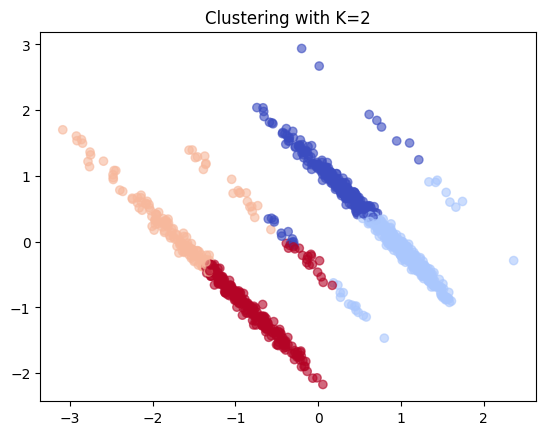

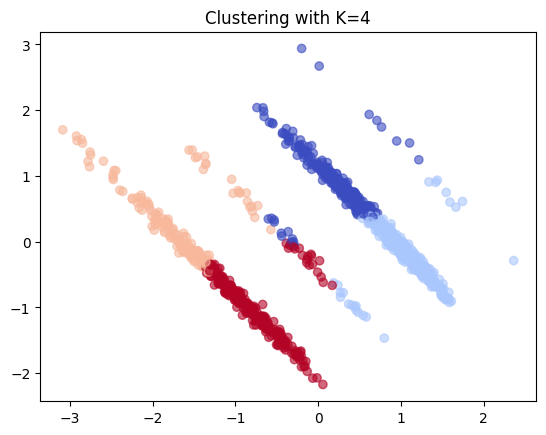

In [48]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df[survey_columns])

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=df['kmeans_cluster_2'], cmap='coolwarm', alpha=0.6)
plt.title("Clustering with K=2")
plt.show()

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=df['kmeans_cluster_4'], cmap='coolwarm', alpha=0.6)
plt.title("Clustering with K=4")
plt.show()

## Clustering Model

### *1️⃣ K-Means*

In [ ]:

# בחירת מספר הקלאסטרים לפי הבדיקה הקודמת
optimal_k = 2  # לדוגמה, אם ראינו שהכי טוב להשתמש ב-3

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['kmeans_cluster'] = kmeans.fit_predict(df[survey_columns])

# הצגת ממוצעי התשובות בכל קלאסטר
df.groupby('kmeans_cluster')[survey_columns].mean()

,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,...,q33,q34,q35,q36,q71,q72,q73,q74,q75,q76
kmeans_cluster,,,,,,,,,,,,,,,,,,,,,
0,0.726108,0.736121,0.702936,0.644214,0.623057,0.785838,0.759931,0.596718,0.601295,0.776770,...,0.711695,0.610104,0.577720,0.647956,0.655872,0.564767,0.769862,0.734456,0.729706,0.407168
1,0.845047,0.757475,0.832300,0.762016,0.699845,0.878295,0.823256,0.710336,0.673488,0.860724,...,0.680177,0.797674,0.685271,0.801292,0.805943,0.706460,0.852713,0.851938,0.841860,0.474160


### *2️⃣ GMM*

In [ ]:
gmm = GaussianMixture(n_components=optimal_k, random_state=42)
df['gmm_cluster'] = gmm.fit_predict(df[survey_columns])

# הצגת ממוצעי התשובות בכל קלאסטר
df.groupby('gmm_cluster')[survey_columns].mean()

,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,...,q33,q34,q35,q36,q71,q72,q73,q74,q75,q76
gmm_cluster,,,,,,,,,,,,,,,,,,,,,
0,0.737594,0.742545,0.716019,0.656149,0.632039,0.794498,0.766990,0.602751,0.605583,0.786003,...,0.706484,0.627427,0.595874,0.661543,0.673544,0.581715,0.783172,0.746764,0.739078,0.420712
1,0.842398,0.754096,0.829025,0.759020,0.697092,0.876414,0.821217,0.711093,0.673667,0.858104,...,0.682322,0.794023,0.677706,0.798690,0.800485,0.701131,0.847334,0.848681,0.840334,0.467959


###  *3️⃣ DBSCAN*

In [56]:
# DBSCAN רגיש מאוד לסקאלה, לכן נבצע נורמליזציה
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[survey_columns])

# הפעלת DBSCAN עם ערכי ברירת מחדל (ניתן לכוונן)
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['dbscan_cluster'] = dbscan.fit_predict(scaled_data)

# הצגת מספר החולים בכל קלאסטר (DBSCAN מחזיר -1 לנקודות חריגות)
print("\nDBSCAN Cluster Counts:")
print(df['dbscan_cluster'].value_counts())

# הצגת ממוצעי התשובות בכל קלאסטר (ללא חריגים)
valid_clusters = df[df['dbscan_cluster'] != -1]  # הסרת נקודות חריגות
print("\nDBSCAN Cluster Means:")
print(valid_clusters.groupby('dbscan_cluster')[survey_columns].mean())


DBSCAN Cluster Counts:
dbscan_cluster
-1    1031
Name: count, dtype: int64

DBSCAN Cluster Means:
Empty DataFrame
Columns: [q1, q2, q3, q4, q5, q6, q7, q8, q9, q10, q12, q13, q14, q15, q16, q17, q18, q19, q20, q21, q22, q23, q24, q25, q26, q27, q28, q29, q30, q31, q33, q34, q35, q36, q71, q72, q73, q74, q75, q76]
Index: []

[0 rows x 40 columns]


## Feature Engineering

#### Patients admitted voluntarily but later received involuntary treatment during their hospitalization.

In [45]:
df['forced_during_agreed'] = ((df['q42'] == 1) & (df['q43'] == 1)).astype(int)